In [57]:
#import packages needed for analysis
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from sklearn import feature_selection


In [65]:
# load in bike share dataset
bike_data = pd.read_csv('../data/bikeshare.csv')
bike_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Here is the data dictionary for this: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset <br>

**Knowledge Check:** which of these variables categorical?  How do you know?<br>
**Answer:** weathersit, season are examples of categorical variables.  You know by looking at the data dictionary and using a little common sense.  It is not sufficient to see that the column includes numbers and assume the variable is numeric!  The number scale may be representing an underlying categorical scale.

### We want to investigate how temperature, humidity and season are associated with numbers of casual riders.

/Users/pt/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:3369: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "the passed axes is being cleared", UserWarning)


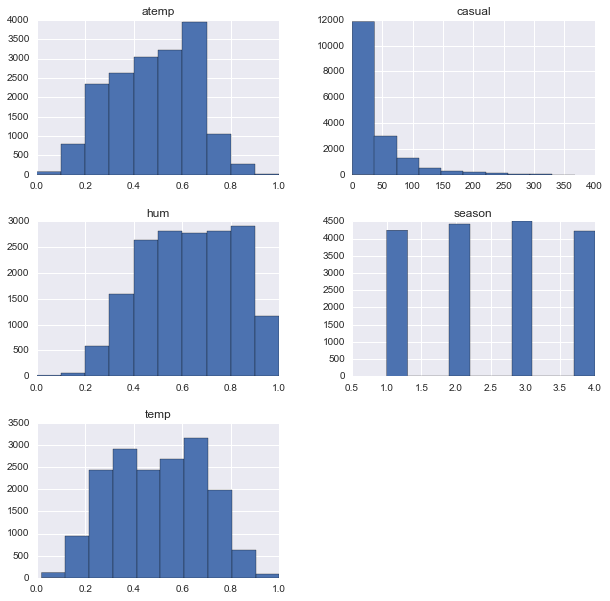

In [73]:
# visualize the distribution of each of these variables.
columns_to_keep = ["casual", "season", "temp", "atemp", "hum"]
sub_data = bike_data[columns_to_keep]
fig, ax = plt.subplots(figsize=(10,10))
sub_data.hist(ax=ax);

**Knowledge check:** what type of variable is season?  What do we need to do before we can use it in the linear regression model?<br>
**Answer:** it's categorical!  So we need to convert it to dummy variables before it goes into the linear model.

In [67]:
# convert season into dummies
seasons = pd.get_dummies(sub_data.season, prefix='season')
seasons.head()

,season_1,season_2,season_3,season_4
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [68]:
# replace the original season column in the dataframe with the dummy variable columns 
sub_data = sub_data.join(seasons).drop("season", axis=1)
sub_data.head()

,casual,temp,atemp,hum,season_1,season_2,season_3,season_4
0,3,0.24,0.2879,0.81,1.0,0.0,0.0,0.0
1,8,0.22,0.2727,0.80,1.0,0.0,0.0,0.0
2,5,0.22,0.2727,0.80,1.0,0.0,0.0,0.0
3,3,0.24,0.2879,0.75,1.0,0.0,0.0,0.0
4,0,0.24,0.2879,0.75,1.0,0.0,0.0,0.0


In [69]:
# show a correlation matrix for all the variables
sub_data.corr()

,casual,temp,atemp,hum,season_1,season_2,season_3,season_4
casual,1.000000,0.459616,0.454080,-0.347028,-0.246476,0.123983,0.175067,-0.057646
temp,0.459616,1.000000,0.987672,-0.069881,-0.583859,0.144363,0.642516,-0.217601
atemp,0.454080,0.987672,1.000000,-0.051918,-0.587470,0.151903,0.619570,-0.198218
hum,-0.347028,-0.069881,-0.051918,1.000000,-0.135138,-0.000625,0.018184,0.117326
season_1,-0.246476,-0.583859,-0.587470,-0.135138,1.000000,-0.331312,-0.335693,-0.322401
season_2,0.123983,0.144363,0.151903,-0.000625,-0.331312,1.000000,-0.344433,-0.330795
season_3,0.175067,0.642516,0.619570,0.018184,-0.335693,-0.344433,1.000000,-0.335169
season_4,-0.057646,-0.217601,-0.198218,0.117326,-0.322401,-0.330795,-0.335169,1.000000


### Ok, now using either statsmodel or sklearn, fit a linear model predicting casual (the outcome) using the other variables we've selected.  Show the coefficients, intercept, pvalues and r2.

In [70]:
# statsmodel
lm_stats = smf.ols(formula='casual ~ temp + atemp + hum + season_1 + season_2 + season_3 + season_4', data=sub_data).fit()
lm_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1428.
Date:                Fri, 07 Oct 2016   Prob (F-statistic):               0.00
Time:                        11:10:58   Log-Likelihood:                -88919.
No. Observations:               17379   AIC:                         1.779e+05
Df Residuals:                   17372   BIC:                         1.779e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     13.4872      1.471      9.167      0.000        10.603    16.371
temp         112.8257     10.698     10.546      0.000        91.856   133.796
atemp         28.0793     11.582      2.424      0.015         5.377    50.782
hum          -80.4242      1.647    -48.831      0.000       -83.653   -77.196
season_1       5.4359      0.600      9.065      0.000         4.260     6.611
season_2       7.0326      0.717      9.813      0.000         5.628     8.437
season_3     -10.3994      1.028    -10.119      0.000       -12.414    -8.385
season_4      11.4181      0.625     18.281      0.000        10.194    12.642
==============================================================================
Omnibus:                     9107.798   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73180.930
Skew:                           2.413   Prob(JB):                         0.00
Kurtosis:                      11.819   Cond. No.                     3.02e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.08e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [71]:
# sklearn
# instantiate a linear model
lm_sk = LinearRegression()
# set our variables
X = sub_data.loc[:,["temp","atemp", "hum","season_1","season_2","season_3", "season_4"]]
y = sub_data["casual"]
#fit the model
lm_sk.fit(X,y)
#print the attributes
print "coefficients:", lm_sk.coef_
print "intercept:", lm_sk.intercept_
print "r2:", lm_sk.score(X,y)
print feature_selection.f_regression(X, y)[1]

coefficients: [  1.12825662e+02   2.85006605e+01  -8.02750450e+01  -1.19919917e+14
  -1.19919917e+14  -1.19919917e+14  -1.19919917e+14]
intercept: 1.19919917308e+14
r2: 0.330267555787
[  0.00000000e+000   0.00000000e+000   0.00000000e+000   7.90819136e-239
   1.70941845e-060   1.20544330e-119   2.84549156e-014]


**Knowledge check:** hold on.  Was that right?  Don't we have to watch out for colinearity?<br>
**Answer** no that wasn't really right, and yes we do.  Remember: when we're looking at a set of predictor variables, we need to take care if they are highly correlated with each other.  But why when the model seems to work?  Because, if we have highly correlated predictors, we can't rely on the coefficient estimates the model produces.  The model simply can't decipher the effect of each predictor.  So, although you might get a result, it may not mean very much!  Garbage in, garbage out!<br>
So what should we do?<br>
Recall from the work in class, if you look at the correlation matrix, you will see that temp and atemp are very highly correlated with each other.  So we shouldn't use both in the model.  We need to drop one.  Also, we created four dummy variable columns to represent the four season categories.  Again, we need to drop one of these.

### Repeat the above linear modelling exercise, but first drop the appropriate variables from the dataframe

In [72]:
# drop atemp and one of the season dummies
sub_data.drop(["atemp","season_4"], axis=1, inplace=True)

In [60]:
# statsmodel
lm_stats = smf.ols(formula='casual ~ temp + hum + season_1 + season_2 + season_3', data=sub_data).fit()
lm_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 casual   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     1712.
Date:                Fri, 07 Oct 2016   Prob (F-statistic):               0.00
Time:                        11:02:03   Log-Likelihood:                -88922.
No. Observations:               17379   AIC:                         1.779e+05
Df Residuals:                   17373   BIC:                         1.779e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     25.6520      1.808     14.188      0.000        22.108    29.196
temp         137.9774      2.612     52.815      0.000       132.857   143.098
hum          -79.9980      1.638    -48.844      0.000       -83.208   -76.788
season_1      -6.1298      0.955     -6.421      0.000        -8.001    -4.259
season_2      -4.4821      0.923     -4.857      0.000        -6.291    -2.673
season_3     -22.1813      1.132    -19.590      0.000       -24.401   -19.962
==============================================================================
Omnibus:                     9130.255   Durbin-Watson:                   0.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73636.905
Skew:                           2.419   Prob(JB):                         0.00
Kurtosis:                      11.848   Cond. No.                         14.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
#sklearn
lm_sk = LinearRegression()
X = sub_data.loc[:,["temp","hum","season_1","season_2","season_3"]]
y = sub_data["casual"]

lm_sk.fit(X,y)
print "coefficients:", lm_sk.coef_
print "intercept:", lm_sk.intercept_
print "r2:", lm_sk.score(X,y)
print feature_selection.f_regression(X, y)[1]

coefficients: [ 137.97737895  -79.99804024   -6.12982135   -4.48207579  -22.18132428]
intercept: 25.651988429
r2: 0.330065273776
[  0.00000000e+000   0.00000000e+000   7.90819136e-239   1.70941845e-060
   1.20544330e-119]


**Knowledge check:** pick a coefficient, and interpret its value.  What does the p-value indicate?  Also, what is the r2, and how should you interpret that?

**Answer:** for example, the hum coefficient is -80.  So keeping all the other variables in the model constant (temperature and season), for each increase in a unit of humidity, on average we expect casual ridership to go down 80 units.  <br>
The p-value is ~0.  Remember, to get this p-value, we are actually doing a hypothesis test.  Our null hypothesis in this case is that there is no linear relationship between humidity and casual ridership.  But our p-value is very small, which suggests to us that if this null hypothesis were true, we would be extremely unlikely to see a coefficient of this magnitude.  So we have reason to reject the null, and conclude that the coefficient is signficant. <br>
R2 is 0.33.  This means that 33% of the variance we see in our outcome (casual ridership) can be explained by the variance in our predictor variables (temperature, humidity and season).